In [1]:
import os
cwd = os.getcwd()
print(cwd)
os.chdir(r'D:\Analytics')

D:\Analytics


In [2]:
import pandas as pd
import multiprocessing
import librosa
import scipy as sp
import zipfile as zf
import time
import numpy as np
import matplotlib.pyplot as plt
import librosa.display

In [3]:
archives = os.listdir()
print(archives)

['.ipynb_checkpoints', 'David Bowie – Life On Mars (Official Video)-AZKcl4-tcuo.mp3', 'fma_small', 'fma_small.zip', "Lead Belly 'In the Pines'-2MkfTYPmLlA.mp3", 'Librosa and youtube converter ex.ipynb', 'Nirvana - Where Did You Sleep Last Night (Live On MTV Unplugged Unedited)-hEMm7gxBYSc.mp3', 'Rick Astley - Never Gonna Give You Up (Video)-dQw4w9WgXcQ.mp3', 'single_threaded', 'single_threaded.csv', 'spectrograms', 'workers.py', 'working.ipynb', '__pycache__']


In [4]:
zip_dir = 'fma_small.zip'
print(zip_dir)

fma_small.zip


In [5]:
with zf.ZipFile(zip_dir) as myzip:
    zip_list = [file for file in myzip.namelist() if '.mp3' in file]
print(zip_list)

['fma_small/000/000002.mp3', 'fma_small/000/000005.mp3', 'fma_small/000/000010.mp3', 'fma_small/000/000140.mp3', 'fma_small/000/000141.mp3', 'fma_small/000/000148.mp3', 'fma_small/000/000182.mp3', 'fma_small/000/000190.mp3', 'fma_small/000/000193.mp3', 'fma_small/000/000194.mp3', 'fma_small/000/000197.mp3', 'fma_small/000/000200.mp3', 'fma_small/000/000203.mp3', 'fma_small/000/000204.mp3', 'fma_small/000/000207.mp3', 'fma_small/000/000210.mp3', 'fma_small/000/000211.mp3', 'fma_small/000/000212.mp3', 'fma_small/000/000213.mp3', 'fma_small/000/000255.mp3', 'fma_small/000/000256.mp3', 'fma_small/000/000368.mp3', 'fma_small/000/000424.mp3', 'fma_small/000/000459.mp3', 'fma_small/000/000534.mp3', 'fma_small/000/000540.mp3', 'fma_small/000/000546.mp3', 'fma_small/000/000574.mp3', 'fma_small/000/000602.mp3', 'fma_small/000/000615.mp3', 'fma_small/000/000620.mp3', 'fma_small/000/000621.mp3', 'fma_small/000/000625.mp3', 'fma_small/000/000666.mp3', 'fma_small/000/000667.mp3', 'fma_small/000/0006

In [6]:
def feature_extraction(file):
    name = file
    try:
        x, sr = librosa.load(file, sr=None, mono=True)  # we don't want to save the waveform to file
    except:
        print("Error with librosa on: ", file)
        return 0
    # TODO: look into all of the feature extraction that we need to compute now

    # Time-Domain Features:
    
    # central moments of the amplitude calculation
    x_mean = np.mean(x)
    x_stdev = np.std(x)
    x_kurtosis = sp.stats.kurtosis(x)
    x_skew = sp.stats.skew(x)
    
    # zero-crossing rate
    zcr = librosa.feature.zero_crossing_rate(x)
    zcr_mean = np.mean(zcr)
    zcr_stdev = np.std(zcr)
    zcr_kurtosis = sp.stats.kurtosis(zcr, axis=None)
    zcr_skew = sp.stats.skew(zcr, axis=None)
    
    # rms
    rms = librosa.feature.rmse(x)
    rms_mean = np.mean(rms)
    rms_stdev = np.std(rms)
    rms_kurtosis = sp.stats.kurtosis(rms, axis=None)
    rms_skew = sp.stats.skew(rms, axis=None)
    
    # tempo (mean and variance)
    onset_env = librosa.onset.onset_strength(x, sr=sr)
    tempo = librosa.beat.tempo(x, onset_envelope=onset_env, sr=sr)[0]  # single estimated tempo
    tempo_dynamic = librosa.beat.tempo(x, onset_envelope=onset_env, sr=sr, aggregate=None)
    tempo_mean = np.mean(tempo_dynamic)
    tempo_stdev = np.std(tempo_dynamic)
    tempo_kurtosis = sp.stats.kurtosis(tempo_dynamic, axis=None)
    tempo_skew = sp.stats.kurtosis(tempo_dynamic, axis=None)
    
    # length
    piece_length = librosa.get_duration(y=x, sr=sr)
    
    # Spectral Features:
    
    # save spectrogram as its own image
    spectrogram_dir = r'D:\Analytics\spectrograms'
    stft = np.abs(librosa.stft(x, n_fft=2048, hop_length=512))  # will reuse for remainder of spectral features
    mel = librosa.feature.melspectrogram(sr=sr, S=stft**2)
    log_mel = librosa.amplitude_to_db(mel)  # want to save the log_mel (dB conversion)
    plt.figure(figsize=(12,4))
    ax = plt.axes()
    plt.set_cmap('hot')
    ax.set_axis_off()
    librosa.display.specshow(log_mel, sr=sr, hop_length=512, x_axis='time', y_axis='mel')
    output_name = ''
    for char in name:
        output_name += char
        if char == '/':
            output_name = ''
    output_name = output_name[:-4] + '.png'
    plt.savefig(spectrogram_dir+'\\'+output_name, bbox_inches='tight', transparent=True, pad_inches=0.0)
    
    # mel-frequency cepstral coeffs (MFCC)
    mfcc = librosa.feature.mfcc(S=librosa.power_to_db(mel), n_mfcc=20)
    mfcc_mean = np.mean(mfcc)
    mfcc_stdev = np.std(mfcc)
    mfcc_kurtosis = sp.stats.kurtosis(mfcc, axis=None)
    mfcc_skew = sp.stats.skew(mfcc, axis=None)
    
    # chroma feature vectors
    chroma = librosa.feature.chroma_stft(S=stft, sr=sr)
    chroma_mean = np.mean(chroma)  # average chroma value should correspond to key of the piece
    chroma_stdev = np.std(chroma)
    chroma_kurtosis = sp.stats.kurtosis(chroma, axis=None)
    chroma_skew = sp.stats.skew(chroma, axis=None)
    
    # spectral centroid
    S, phase = librosa.magphase(stft)  # does magphase care if the stft is alread the abs?
    spectral_centroid = librosa.feature.spectral_centroid(S=S)  # can we just pass ab
    spectral_centroid_mean = np.mean(spectral_centroid)
    spectral_centroid_stdev = np.std(spectral_centroid)
    spectral_centroid_kurtosis = sp.stats.kurtosis(spectral_centroid, axis=None)
    spectral_centroid_skew = sp.stats.skew(spectral_centroid, axis=None)
    
    # spectral bandwidth
    spectral_bandwidth = librosa.feature.spectral_bandwidth(S=S)
    spectral_bandwidth_mean = np.mean(spectral_bandwidth)
    spectral_bandwidth_stdev = np.std(spectral_bandwidth)
    spectral_bandwidth_kurtosis = sp.stats.kurtosis(spectral_bandwidth, axis=None)
    spectral_bandwidth_skew = sp.stats.skew(spectral_bandwidth, axis=None)
    
    # spectral contrast
    contrast = librosa.feature.spectral_contrast(S=stft, sr=sr)
    contrast_mean = np.mean(contrast)
    contrast_stdev = np.std(contrast)
    contrast_kurtosis = sp.stats.kurtosis(contrast, axis=None)
    contrast_skew = sp.stats.skew(contrast, axis=None)
    
    # spectral rolloff
    rolloff = librosa.feature.spectral_rolloff(S=S)
    rolloff_mean = np.mean(rolloff)
    rolloff_stdev = np.std(rolloff)
    rolloff_kurtosis = sp.stats.kurtosis(rolloff, axis=None)
    rolloff_skew = sp.stats.skew(rolloff, axis=None)
    
    # Additional Features that We didn't say we'd include, but might be useful:
    
    # spectral flatness
    flatness = librosa.feature.spectral_flatness(S=S) #  a high flatness means it is close to noise
    flatness_mean = np.mean(flatness)
    flatness_stdev = np.std(flatness)
    flatness_kurtosis = sp.stats.kurtosis(flatness, axis=None)
    flatness_skew = sp.stats.skew(flatness, axis=None)
    
    data_dict = {'name': [name],'x_mean': [x_mean], 'x_stdev': [x_stdev], 'x_kurtosis': [x_kurtosis], 'x_skew': [x_skew], 'zcr_mean': [zcr_mean], 'zcr_stdev': [zcr_stdev], 'zcr_kurtosis': 
                 [zcr_kurtosis], 'zcr_skew': [zcr_skew], 'rms_mean': [rms_mean], 'rms_stdev': [rms_stdev], 'rms_kurtosis': [rms_kurtosis], 'rms_skew': [rms_skew], 'tempo': 
                 [tempo], 'mean_dynamic_tempo': [tempo_mean], 'stdev_dynamic_tempo': [tempo_stdev], 'kurtosis_dynamic_tempo': [tempo_kurtosis], 'skew_dynamic_tempo': [tempo_skew],
                 'length': [piece_length], 'mfcc_mean': [mfcc_mean], 'mfcc_stdev': [mfcc_stdev], 'mfcc_kurtosis': [mfcc_kurtosis], 'mfcc_skew': [mfcc_skew], 'chroma_mean':
                 [chroma_mean], 'chroma_stdev': [chroma_stdev], 'chroma_kurtosis': [chroma_kurtosis], 'chroma_skew': [chroma_skew], 'spectral_centroid_mean': 
                 [spectral_centroid_mean], 'spectral_centroid_stdev': [spectral_centroid_stdev], 'spectral_centroid_kurtosis': [spectral_centroid_kurtosis],
                 'spectral_centroid_skew': [spectral_centroid_skew], 'spectral_bandwidth_mean': [spectral_bandwidth_mean], 'spectral_bandwidth_stdev': [spectral_bandwidth_stdev],
                 'spectral_bandwidth_kurtosis': [spectral_bandwidth_kurtosis], 'spectral_bandwidth_skew': [spectral_bandwidth_skew], 'spectral_contrast_mean': [contrast_mean],
                 'spectral_contrast_stdev': [contrast_stdev], 'spectral_contrast_kurtosis': [contrast_kurtosis], 'spectral_contrast_skew': [contrast_skew], 
                 'spectral_rolloff_mean': [rolloff_mean], 'spectral_rolloff_stdev': [rolloff_stdev], 'spectral_rolloff_kurtosis': [rolloff_kurtosis], 'spectral_rolloff_skew':
                 [rolloff_skew], 'spectral_flatness_mean': [flatness_mean], 'spectral_flatness_stdev': [flatness_stdev], 'spectral_flatness_kurtosis': [flatness_kurtosis],
                 'spectral_flatness_skew': [flatness_skew]}
    #print(data_dict)
    extracted_features = pd.DataFrame(data_dict)
    #print(extracted_features)
    extracted_features.to_csv('extracted_audio_features.csv', mode='a', header=False)
    
    return 0
    
def create_csv():
    files = os.listdir()
    if 'extracted_audio_features.csv' not in files:
        audio_data = pd.DataFrame(columns=['names','x_mean','x_stdev','x_kurtosis','x_skew','zcr_mean','zcr_stdev','zcr_kurtosis','zcr_skew','rms_mean','rms_stdev',
                                          'rms_kurtosis','rms_skew','tempo','mean_dynamic_tempo','stdev_dynamic_tempo','kurtosis_dynamic_tempo','skew_dynamic_tempo',
                                          'length','mfcc_mean','mfcc_stdev','mfcc_kurtosis','mfcc_skew','chroma_mean','chroma_stdev','chroma_kurtosis','chroma_skew',
                                          'spectra_centroid_mean','spectral_centroid_stdev','spectral_centroid_kurtosis','spectral_centroid_skew',
                                          'spectral_bandwidth_mean','spectral_bandwidth_stdev','spectral_bandwidth_kurtosis','spectral_bandwidth_skew',
                                          'spectral_contrast_mean','spectral_contrast_stdev','spectral_contrast_kurtosis','spectral_contrast_skew','spectal_rolloff_mean',
                                          'spectral_rolloff_stdev','spectral_rolloff_kurtosis','spectral_rolloff_skew','spectral_flatness_mean',
                                          'spectral_flatness_stdev','spectral_flatness_kurtosis','spectral_flatness_skew'])
        audio_data.to_csv('extracted_audio_features.csv')


## Single-Threaded Version ##

KeyboardInterrupt: 

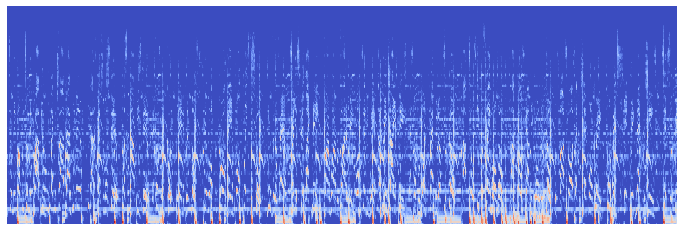

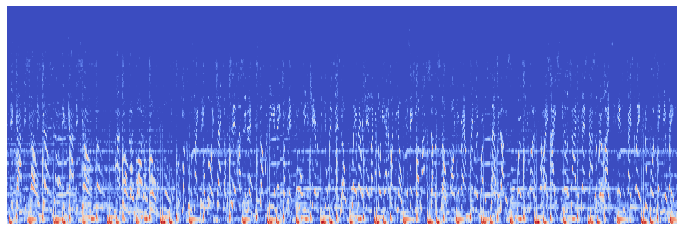

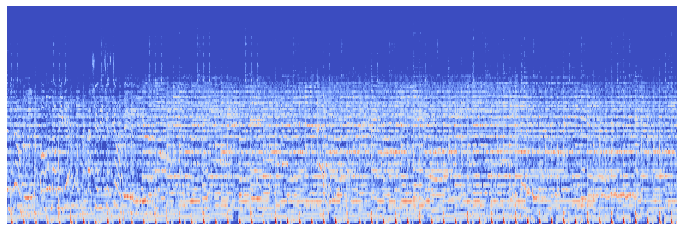

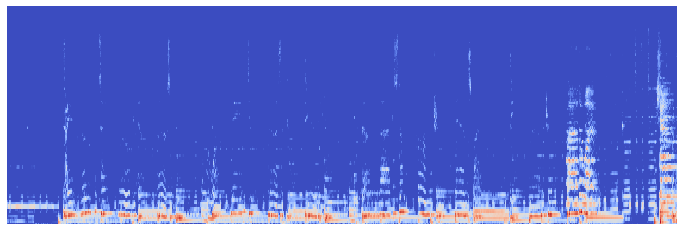

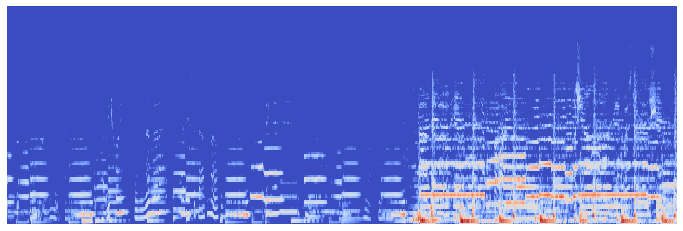

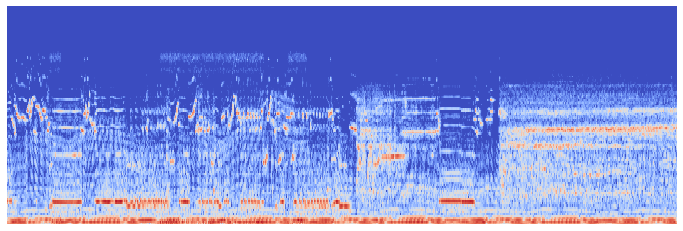

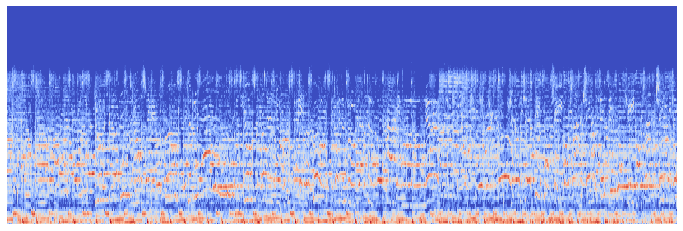

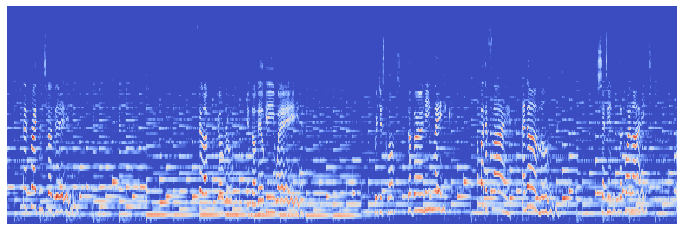

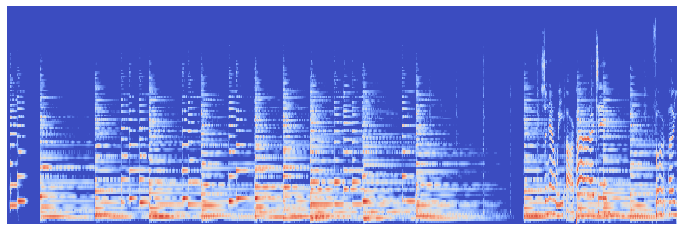

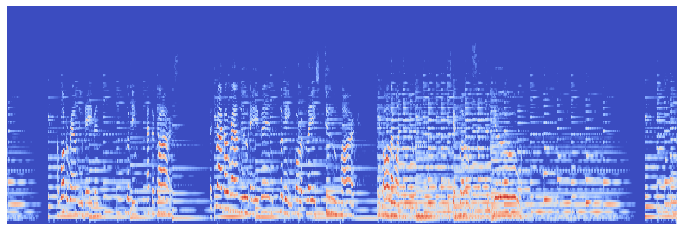

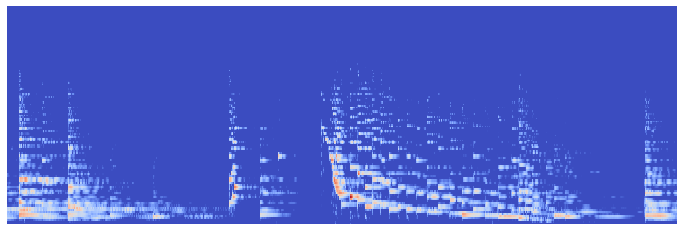

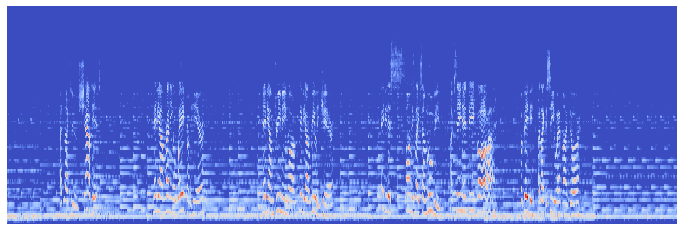

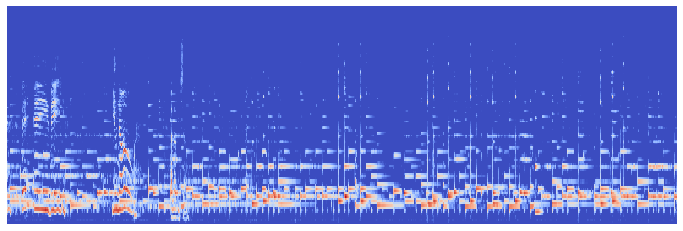

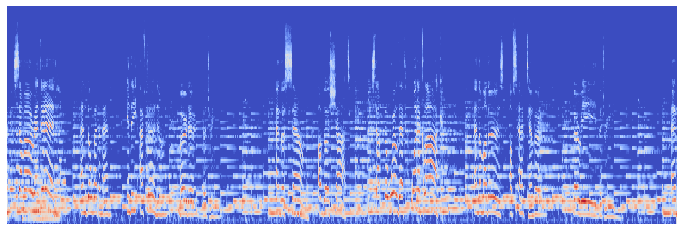

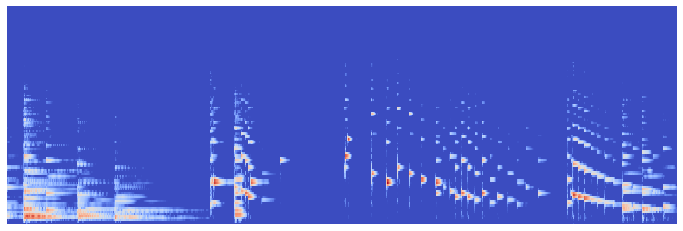

In [15]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
time_start = time.time()
create_csv()
with zf.ZipFile(zip_dir) as myzip:
    zip_list = [file for file in myzip.namelist() if '.mp3' in file]
    zip_list = zip_list[:100]
    for zipped_file in zip_list:
        del_path = myzip.extract(zipped_file)  # path to remove when completed
        feature_extraction(zipped_file)
        os.remove(del_path)  # delete file when finished
time_stop = time.time()
total_time = time_stop - time_start
print("total time: ", total_time)

In [7]:
import workers
import functools

In [11]:
### Experimental Code for multiprocessing zip-file objects - not working yet, do not run ###
"""  
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
time_start = time.time()
workers.create_csv()
with zf.ZipFile(zip_dir) as myzip:
    zip_list = [file for file in myzip.namelist() if '.mp3' in file]
    zip_list = zip_list[:100]
    mz = zip_dir
    print(type(mz))
    print(mz)
    if __name__=='__main__':
        with multiprocessing.pool.ThreadPool as pool:
            func = functools.partial(workers.feature_extraction, mz)  # issues with passing byte object, might need to internalize all zip operations to feature_extraction
            pool.map(func, zip_list)
time_stop = time.time()
total_time = time_stop - time_start
print("total time: ", total_time)
"""

'  \nimport warnings\nwarnings.filterwarnings(\'ignore\')\nwarnings.simplefilter(\'ignore\')\ntime_start = time.time()\nworkers.create_csv()\nwith zf.ZipFile(zip_dir) as myzip:\n    zip_list = [file for file in myzip.namelist() if \'.mp3\' in file]\n    zip_list = zip_list[:100]\n    mz = zip_dir\n    print(type(mz))\n    print(mz)\n    if __name__==\'__main__\':\n        with multiprocessing.pool.ThreadPool as pool:\n            func = functools.partial(workers.feature_extraction, mz)  # issues with passing byte object, might need to internalize all zip operations to feature_extraction\n            pool.map(func, zip_list)\ntime_stop = time.time()\ntotal_time = time_stop - time_start\nprint("total time: ", total_time)\n'

In [8]:
# single_threaded on extracted data to perform the feature extraction
from workers import feature_extraction_from_file
extracted_dir = r'fma_small'
# build the complete directory list
file_list = []
for folder in os.listdir(extracted_dir):
    file_list += ([extracted_dir+'\\'+folder+'\\'+file for file in os.listdir(extracted_dir+'\\'+folder) if '.mp3' in file])
test_list = file_list[:100]
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
time_start = time.time()
create_csv()
for file in test_list:
    feature_extraction_from_file(file)
time_stop = time.time()
total_time = time_stop - time_start
print("total time: ", total_time)

total time:  282.8168272972107


## Multiprocessed Code for extracting datasets - change as required for individual datasets ##

In [9]:
# multiprocessed on extracted data to perform the feature extraction
from workers import feature_extraction_from_file
extracted_dir = r'fma_small'  # change this directory as needed
file_list = []
for folder in os.listdir(extracted_dir):
    file_list += ([extracted_dir+'\\'+folder+'\\'+file for file in os.listdir(extracted_dir+'\\'+folder) if '.mp3' in file])
test_list = file_list[:100]
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
time_start = time.time()
create_csv()
if __name__ == '__main__':
    with multiprocessing.Pool() as pool:
        pool.map(feature_extraction_from_file, file_list)
time_stop = time.time()
total_time = time_stop - time_start
print("total time: ", total_time)

total time:  32617.642280817032


In [13]:
# multiprocessed on extracted data to perform the feature extraction
from workers import feature_extraction_from_file
extracted_dir = r'genres'  # change this directory as needed
file_list = []
for folder in os.listdir(extracted_dir):
    file_list += ([extracted_dir+'\\'+folder+'\\'+file for file in os.listdir(extracted_dir+'\\'+folder) if '.wav' in file])
test_list = file_list[:100]
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
time_start = time.time()
create_csv()
if __name__ == '__main__':
    with multiprocessing.Pool() as pool:
        pool.map(feature_extraction_from_file, file_list)
time_stop = time.time()
total_time = time_stop - time_start
print("total time: ", total_time)

total time:  294.0593671798706
